# Complex source reconstruction using _starlets_ with point sources

The complex source surface brightness is solved using sparsity constrains in starlets space, and the linear amplitude of point sources (lensed quasar images) are optimized through weight least square (as in _lenstronomy_).

In [1]:
__author__ = 'aymgal'

%matplotlib inline

import matplotlib.pyplot as plt
plt.rc('image', interpolation='none', origin='lower')

import os
import sys
import copy
import time
import pprint
import pickle as pkl
import numpy as np
import astropy.io.fits as pf
from matplotlib.colors import LogNorm

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Util import kernel_util

from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
from slitronomy.Util.util import dirac_impulse
from slitronomy.Util.plot_util import nice_colorbar

subgrid_res_source = 3
mock_psf_type = 'hst'  # 'gaussian' or 'hst'

np.random.seed(18)

In [2]:
lin_scale = lambda x: x
log_scale = lambda x: np.log10(x)
sqrt_scale = lambda x: np.sqrt(x)

cmap_flux = copy.copy(plt.get_cmap('cubehelix'))
cmap_flux.set_bad('black')

## Generate a mock lens

In [3]:
# data specifics
num_pix = 100  # cutout pixel size
delta_pix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2)

background_rms = 0.1  # background noise per pixel
exp_time = 400  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)

#psf_error_level = 0.1

In [4]:
# data specification (coordinates, etc.)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, 
                                                 inverse=False, left_lower=False)

kwargs_data = {
    'background_rms': background_rms,
    'exposure_time': exp_time,  # individual exposure time/weight per pixel
    'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
    'transform_pix2angle': Mpix2coord,
    'image_data': np.zeros((num_pix, num_pix))
}
data_class = ImageData(**kwargs_data)

(71, 71) 1.0


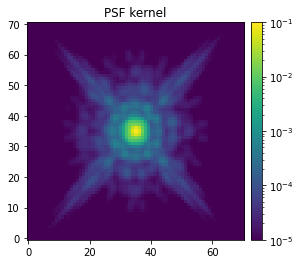

In [5]:
# load HST PSF kernel
with pf.open(os.path.join('data', 'psf', 'psf_tdlmc_rung0.fits')) as f:
    psf_kernel_hst_raw = f[0].data
psf_num_pix = 71
psf_kernel_hst = kernel_util.cut_psf(psf_kernel_hst_raw, psf_num_pix)

# PSF specification
if mock_psf_type == 'hst':
    print(psf_kernel_hst.shape, psf_kernel_hst.sum())
    kwargs_psf = {
        'psf_type': 'PIXEL', 
        'kernel_point_source': psf_kernel_hst,
        #'psf_error_map': psf_error_level * np.ones_like(psf_kernel)
    }
elif mock_psf_type == 'gaussian':
    psf_fwhm = kernel_util.fwhm_kernel(psf_kernel_hst) * delta_pix
    print("estimated FWHM", psf_fwhm)
    psf_kernel_gauss = kernel_util.kernel_gaussian(psf_num_pix, delta_pix, psf_fwhm)
    print(psf_kernel_gauss.shape, psf_kernel_gauss.sum())
    #psf_kernel_hd = kernel_util.kernel_gaussian(int(psf_num_pix*subgrid_res_source), 
    #                                            delta_pix/subgrid_res_source,
    #                                            psf_fwhm)
    kwargs_psf = {
        'psf_type': 'PIXEL', 
        'kernel_point_source': psf_kernel_gauss,
        #'psf_error_map': psf_error_level * np.ones_like(psf_kernel)
    }
psf_class = PSF(**kwargs_psf)

fig = plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 2, 1)
ax.set_title("PSF kernel")
im = ax.imshow(psf_class.kernel_point_source, cmap='viridis', norm=LogNorm(1e-5, 1e-1))
nice_colorbar(im)
if 'psf_error_map' in kwargs_psf:
    ax = plt.subplot(1, 2, 2)
    ax.set_title("PSF error map")
    im = ax.imshow(psf_class.psf_error_map, cmap='viridis')
    nice_colorbar(im)
plt.show()

In [6]:
lens_model_list = ['PEMD', 'SHEAR_GAMMA_PSI']
kwargs_spemd = {'theta_E': 1.8, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.2}
kwargs_shear = {'gamma_ext': 0.05, 'psi_ext': 0.5, 'ra_0': kwargs_spemd['center_x'], 'dec_0': kwargs_spemd['center_y']}
kwargs_lens = [kwargs_spemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of source light profiles
# get an pre-processed source galaxy from galsim
galsim_index = 31
snr = 500
galsim_data_path = ('/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code' +
                    '/Lens_modelling/gravlensgen/Simulations/ring_sims' +
                    '/sims_SNR{}/simring_galsim{}_all.pkl'.format(snr, galsim_index))
[data, truth, lens_model] = pkl.load(open(galsim_data_path, 'rb'))
galsim_source_highres = truth['source_galsim_3']
galsim_num_pix = data['num_pix']
galsim_delta_pix = data['delta_pix']
source_model_list = ['INTERPOL']
kwargs_interpol_source = {'image': galsim_source_highres, 'amp': 3000, 'center_x': +0.3, 'center_y': -0.1, 'phi_G': 0, 
                          'scale': galsim_delta_pix/3}
kwargs_source = [kwargs_interpol_source]
source_model_class = LightModel(light_model_list=source_model_list)

# list of lens light profiles
lens_light_model_list = []
kwargs_lens_light = [{}]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

# add point sources : solve lens equation from source position to find images
lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(kwargs_source[0]['center_x'], 
                                                      kwargs_source[0]['center_y'], 
                                                      kwargs_lens, numImages=4,
                                                      min_distance=delta_pix, 
                                                      search_window=num_pix*delta_pix)
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
mag_factor = 100
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
              'point_amp': mag_factor*np.abs(mag)}]
num_ps = len(kwargs_ps[0]['point_amp'])
print(kwargs_ps)

point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

[{'ra_image': array([ 1.93029752, -0.02402909,  1.08273339, -1.11603544]), 'dec_image': array([ 0.99330648, -1.88873789, -1.49990435,  0.66386942]), 'point_amp': array([319.18460747, 672.64513689, 611.19244823, 127.53846181])}]


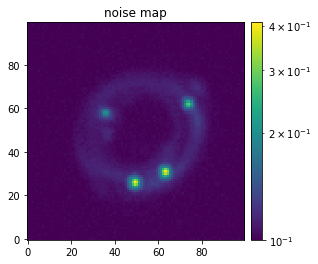

In [7]:
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

# get the simalated lens image (i.e. image plane)
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, 
                        lens_light_model_class, point_source_class=point_source_class, 
                        kwargs_numerics=kwargs_numerics)

image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)

bkg = image_util.add_background(image_sim_no_noise, sigma_bkd=background_rms)
poisson = image_util.add_poisson(image_sim_no_noise, exp_time=exp_time)
noise = bkg + poisson
image_sim = image_sim_no_noise + noise
image_sim_1d = lenstro_util.image2array(image_sim)

kwargs_data['image_data'] = image_sim
if kwargs_data.get('exposure_time', None) is None:
    kwargs_data['noise_map'] = background_rms * np.ones_like(image_sim)
data_class = ImageData(**kwargs_data)

plt.title("noise map")
im = plt.imshow(np.sqrt(data_class.C_D), norm=LogNorm())
nice_colorbar(im)
plt.show()

In [8]:
# get the light distribution in source plane
source_sim = imageModel.source_surface_brightness(kwargs_source, unconvolved=True, de_lensed=True)
source_sim_1d = lenstro_util.image2array(source_sim)

# get the light distribution in source plane convolved
source_sim_conv = imageModel.source_surface_brightness(kwargs_source, unconvolved=False, de_lensed=True)
source_sim_1d_conv = lenstro_util.image2array(source_sim)

# get the light distribution in source plane, convolved and on high res grid
#if psf_kernel_hd is not None:
#    from lenstronomy.ImSim.Numerics.convolution import PixelKernelConvolution
#    conv_hd = PixelKernelConvolution(psf_kernel_hd, convolution_type='fft_static')
#    source_sim_hd_conv = np.copy(conv_hd.convolution2d(source_sim_hd))

    
# get the point source model, for initial guess
init_ps_model = imageModel.point_source(kwargs_ps)

## Visualize the lens & true source

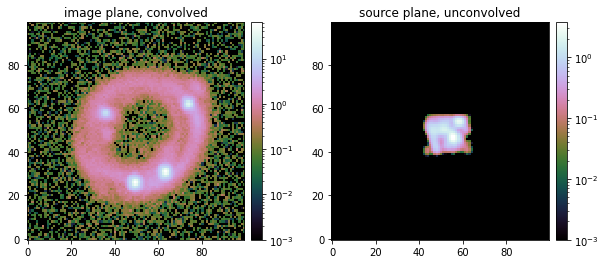

In [9]:
fig = plt.figure(figsize=(10, 4))

ax = plt.subplot2grid((1, 2), (0, 0), fig=fig)
ax.set_title("image plane, convolved")
im = ax.imshow(lin_scale(image_sim), cmap=cmap_flux, norm=LogNorm(1e-3))
nice_colorbar(im)

ax = plt.subplot2grid((1, 2), (0, 1))
ax.set_title("source plane, unconvolved")
im = ax.imshow(lin_scale(source_sim), cmap=cmap_flux, norm=LogNorm(1e-3))
nice_colorbar(im)

plt.show()

## Sparse optimizazion to reconstruct the source light

In [10]:
source_model_list_sparsefit = ['SLIT_STARLETS']
kwargs_starlets_source = {'n_scales': 6, 'n_pixels': np.size(image_sim)*subgrid_res_source**2}  # add center_x/center_y
kwargs_source_sparsefit = [kwargs_starlets_source]
source_model_class_sparsefit = LightModel(light_model_list=source_model_list_sparsefit)

kwargs_ps_sparsefit = copy.deepcopy(kwargs_ps)
kwargs_ps_sparsefit[0]['point_amp'] += 20 * np.random.randn(num_ps)  # disturb initial amplitudes w.r.t. truth

# TEST: displace PS positions
#kwargs_ps_sparsefit[0]['ra_image'] += delta_pix/10. * np.random.randn(num_ps)
#kwargs_ps_sparsefit[0]['dec_image'] += delta_pix/10. * np.random.randn(num_ps)

kwargs_special_sparsefit = {
    'delta_x_source_grid': 0,
    'delta_y_source_grid': 0,
}

#from TDLMCpipeline.Modelling.mask import ImageMask
#likelihood_mask = ImageMask(mask_shape=data_class.data.shape,
#                            delta_pix=data_class.pixel_width,
#                            mask_type='circle', 
#                            radius_list=[3.5],
#                            center_list=[None]).get_mask(show_details=True)

likelihood_mask = None

kwargs_sparse_solver = {
    'supersampling_factor_source': subgrid_res_source,
    'minimal_source_plane': True,
    'min_threshold': 3,
    'num_iter_source': 20,
    'num_iter_global': 5,
    'num_iter_weights': 2,
    'verbose': True,
    'show_steps': False,
    'thread_count': 8,
}

imageSparseFit = ImageLinearFit(data_class, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                point_source_class=point_source_class,
                                likelihood_mask=likelihood_mask,
                                kwargs_pixelbased=kwargs_sparse_solver)

In [11]:
print("Before optimisation:")
print("truth", kwargs_ps[0]['point_amp'])
print("model", kwargs_ps_sparsefit[0]['point_amp'])
print("RMS error", np.sum((kwargs_ps[0]['point_amp'] - kwargs_ps_sparsefit[0]['point_amp'])**2) / num_ps)
print("truth", kwargs_ps[0]['ra_image'])
print("model", kwargs_ps_sparsefit[0]['ra_image'])

Before optimisation:
truth [319.18460747 672.64513689 611.19244823 127.53846181]
model [325.21992268 688.54935237 623.94370714 140.12712157]
RMS error 152.60951441278183
truth [ 1.93029752 -0.02402909  1.08273339 -1.11603544]
model [ 1.93029752 -0.02402909  1.08273339 -1.11603544]


In [12]:
start_time = time.time()
model, _, _, param = imageSparseFit.image_pixelbased_solve(copy.deepcopy(kwargs_lens), 
                                                       kwargs_source=kwargs_source_sparsefit,
                                                       kwargs_lens_light=None,
                                                       kwargs_ps=kwargs_ps_sparsefit,
                                                       kwargs_special=kwargs_special_sparsefit)
end_time = time.time()
print("Runtime : {:.3f} s".format(end_time-start_time))

SizeablePlaneGrid: source grid has been reduced from 300 to 224 side pixels
*** iteration 0-0-0 *** : loss+reg = 580.7675|nan, red-chi2 = 8.1321|nan, step_diff = 29.3838|nan
ps_param [323.06800155 674.42316873 625.66671781 132.29744758]
ps_param [320.57498623 670.23370998 623.38746078 130.84220451]
ps_param [319.37083515 668.82927119 622.16748691 130.17211668]
ps_param [318.85839727 668.25919961 621.63222761 129.88582815]
ps_param [318.64151593 668.02070999 621.40400526 129.76472963]
*** iteration 1-0-0 *** : loss+reg = 120.2948|nan, red-chi2 = 1.8962|nan, step_diff = 10.6464|nan
ps_param [318.09286034 667.80773487 618.45476027 128.30430037]
ps_param [317.54327242 667.16982645 617.64525634 127.91090992]
ps_param [317.26332945 666.8512678  617.34100981 127.73422649]
ps_param [317.1305855  666.70598104 617.2084898  127.65134966]
ps_param [317.06886518 666.63991137 617.14847114 127.61127499]
Runtime : 4.392 s


In [13]:
print("After optimisation:")
print("truth", kwargs_ps[0]['point_amp'])
print("model", kwargs_ps_sparsefit[0]['point_amp'])
print("RMS error", np.sum((kwargs_ps[0]['point_amp'] - kwargs_ps_sparsefit[0]['point_amp'])**2) / num_ps)
print("truth", kwargs_ps[0]['ra_image'])
print("model", kwargs_ps_sparsefit[0]['ra_image'])

After optimisation:
truth [319.18460747 672.64513689 611.19244823 127.53846181]
model [317.06886518 666.63991137 617.14847114 127.61127499]
RMS error 19.004652406118907
truth [ 1.93029752 -0.02402909  1.08273339 -1.11603544]
model [ 1.93029752 -0.02402909  1.08273339 -1.11603544]


## Plot optimization summary

Negative image pixels ? False (min = 1.94e-04)
Negative source pixels ? False (min = 0.00e+00)


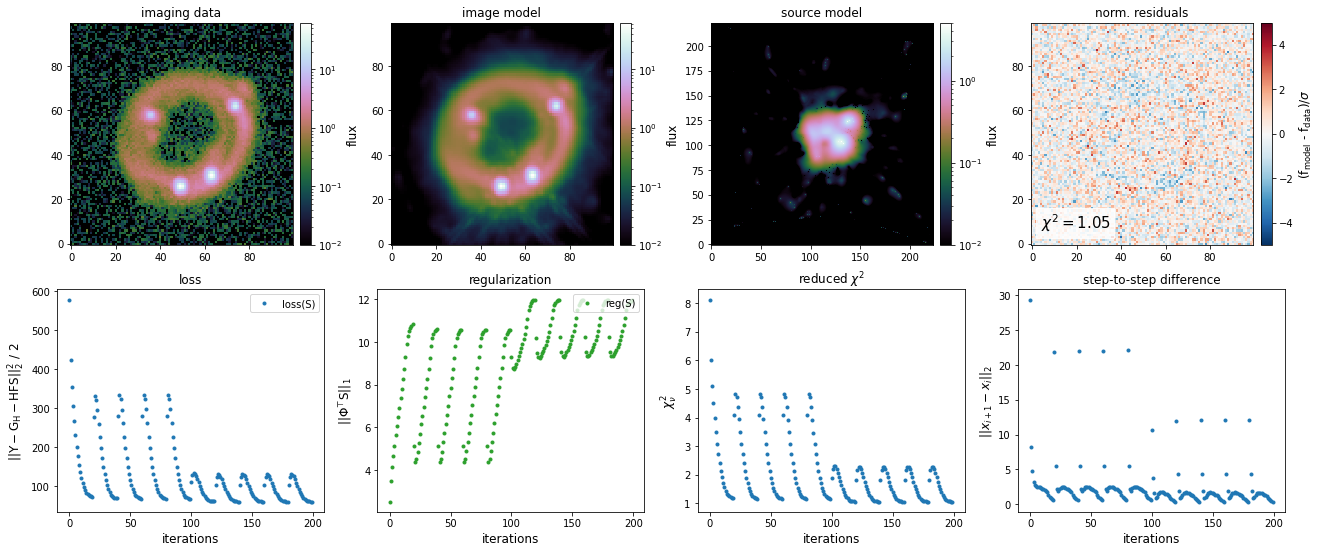

In [14]:
sparseSolver = imageSparseFit.PixelSolver
#lensingOperator = imageSparseFit.lensingOperator

fig = sparseSolver.plot_results(log_scale=True, vmin_res=-5, vmax_res=5, 
                                cmap_image=cmap_flux, cmap_source=cmap_flux,
                                vmin_image=1e-2, vmin_source=1e-2)

## Plot residuals in source plane

In [15]:
# get source reconstructions
source_estimate = imageSparseFit.source_surface_brightness(kwargs_source_sparsefit, kwargs_lens=None, 
                                                           unconvolved=True, de_lensed=True)

ra_grid_hd, dec_grid_hd = lenstro_util.make_grid(numPix=num_pix, deltapix=delta_pix,
                                                 subgrid_res=subgrid_res_source)
#ra_grid_hd, dec_grid_hd = sparseSolver.lensingOperator.sourcePlane.grid()
source_estimate_hd = source_model_class_sparsefit.surface_brightness(ra_grid_hd, dec_grid_hd, kwargs_source_sparsefit)
source_estimate_hd = lenstro_util.array2image(source_estimate_hd)

# get the true light distribution in source plane on high res grid
source_sim_hd = source_model_class.surface_brightness(ra_grid_hd, dec_grid_hd, kwargs_source)
source_sim_hd = lenstro_util.array2image(source_sim_hd)
source_sim_hd *= (delta_pix/subgrid_res_source)**2  # unit conversion
source_sim_hd *= subgrid_res_source**2  # pixeal area ratio

model_unconvolved = imageSparseFit.source_surface_brightness(kwargs_source_sparsefit, kwargs_lens=kwargs_lens,
                                                                  unconvolved=True, de_lensed=False)

SizeablePlaneGrid: source grid has been reduced from 300 to 224 side pixels


SDR = 8.282413374955604
SDR (restricted) = 8.325096946338308
SDR (HD, restricted) = 0.26796914262398375
QOR = 1.0228627811454207
3.7516357719898217 3.3368968168894355 4.0444203615188625 5.0749406814574805


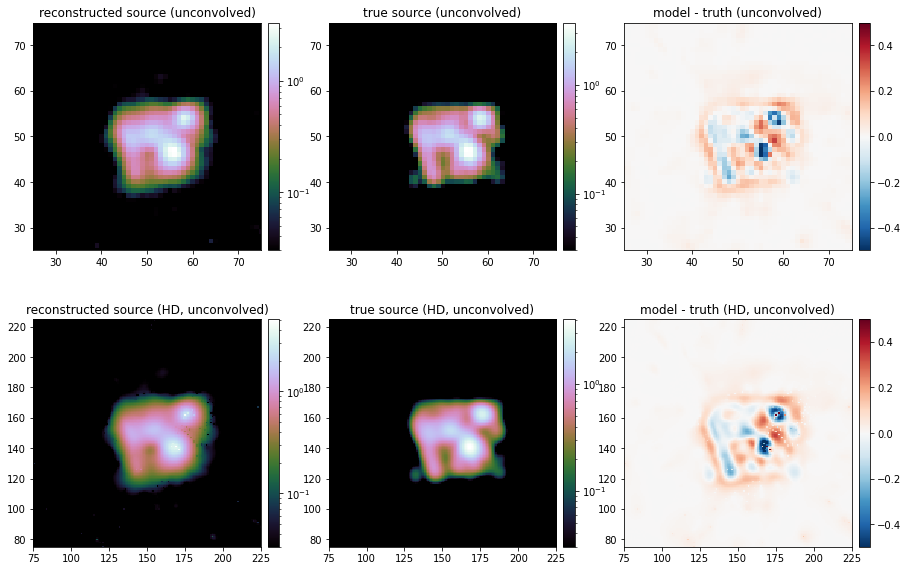

In [16]:
from metrics import SDR, QOR
print("SDR =", SDR(source_sim, source_estimate))
print("SDR (restricted) =", SDR(source_sim[33:63, 38:68], source_estimate[33:63, 38:68]))
print("SDR (HD, restricted) =", SDR(source_sim_hd[66:126, 76:136], source_estimate_hd[66:126, 76:136]))
#plt.imshow(source_sim_hd[66:126, 76:136], origin='lower')

print("QOR =", QOR(image_sim, sparseSolver.image_model(), np.sqrt(data_class.C_D)))

print(source_sim.max(), source_estimate.max(), source_sim_hd.max(), source_estimate_hd.max())
cut_level = 0.5
cut_level_hd = 0.5

residuals_source = source_estimate - source_sim
residuals_source_hd = source_estimate_hd - source_sim_hd

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

ax = axes[0, 0]
ax.set_title("reconstructed source (unconvolved)")
im = ax.imshow(source_estimate, origin='lower', cmap=cmap_flux, norm=LogNorm(3e-2))
ax.set_xlim(len(source_sim)/4, 3*len(source_sim)/4)
ax.set_ylim(len(source_sim)/4, 3*len(source_sim)/4)
nice_colorbar(im)
ax = axes[0, 1]
ax.set_title("true source (unconvolved)")
im = ax.imshow(source_sim, origin='lower', cmap=cmap_flux, norm=LogNorm(3e-2))
ax.set_xlim(len(source_sim)/4, 3*len(source_sim)/4)
ax.set_ylim(len(source_sim)/4, 3*len(source_sim)/4)
nice_colorbar(im)
ax = axes[0, 2]
ax.set_title("model - truth (unconvolved)")
ax.set_xlim(len(source_sim)/4, 3*len(source_sim)/4)
ax.set_ylim(len(source_sim)/4, 3*len(source_sim)/4)
im = ax.imshow(residuals_source, origin='lower', cmap='RdBu_r', vmin=-cut_level, vmax=cut_level)
nice_colorbar(im)

ax = axes[1, 0]
ax.set_title("reconstructed source (HD, unconvolved)")
im = ax.imshow(source_estimate_hd, origin='lower', cmap=cmap_flux, norm=LogNorm(3e-2))
ax.set_xlim(len(source_estimate_hd)/4, 3*len(source_estimate_hd)/4)
ax.set_ylim(len(source_estimate_hd)/4, 3*len(source_estimate_hd)/4)
nice_colorbar(im)
ax = axes[1, 1]
ax.set_title("true source (HD, unconvolved)")
im = ax.imshow(source_sim_hd, origin='lower', cmap=cmap_flux, norm=LogNorm(3e-2))
ax.set_xlim(len(source_sim_hd)/4, 3*len(source_sim_hd)/4)
ax.set_ylim(len(source_sim_hd)/4, 3*len(source_sim_hd)/4)
nice_colorbar(im)
ax = axes[1, 2]
ax.set_title("model - truth (HD, unconvolved)")
ax.set_xlim(len(source_sim_hd)/4, 3*len(source_sim_hd)/4)
ax.set_ylim(len(source_sim_hd)/4, 3*len(source_sim_hd)/4)
im = ax.imshow(residuals_source_hd, origin='lower', cmap='RdBu_r', vmin=-cut_level_hd, vmax=cut_level_hd)
nice_colorbar(im)

plt.show()